# Welter issue #8
## Visual Spectrum
### Notebook 01- Just read it in

Michael Gully-Santiago  
Wednesday, December 30, 2015  

Visual spectrum

In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt

In [2]:
% matplotlib inline
% config InlineBackend.figure_format = 'retina'
import seaborn as sns
sns.set_context('notebook')

# Download it.

Greg provided an ftp link in an email.

In [3]:
! ls /Users/gully/GitHub/welter/data/raw/optical

LkCa4_tspec.fits       lkca4_10jan14.dat      lkca4_18jan14.dat      lkca4_20jan14b.dat
README                 lkca4_14jan14.dat      lkca4_19jan14.dat      lkca4blue_20080121.dat
lkca4_07jan14.dat      lkca4_15jan14.dat      lkca4_20080121.dat     lkca4blue_20081230.dat
lkca4_08jan14.dat      lkca4_16jan14.dat      lkca4_20081230.dat
lkca4_09jan14.dat      lkca4_17jan14.dat      lkca4_20jan14a.dat


In [4]:
! head /Users/gully/GitHub/welter/data/raw/optical/lkca4_10jan14.dat

       369.10345      3.28960
       369.10580     0.155995
       369.10815      6.51284
       369.11050     -6.62671
       369.11285     0.471740
       369.11520      1.54039
       369.11755     0.923922
       369.11990     0.944863
       369.12222    -0.703493
       369.12457      5.29000


In [5]:
! tail /Users/gully/GitHub/welter/data/raw/optical/lkca4_10jan14.dat

       1048.0898     0.781864
       1048.0950     0.774496
       1048.1002     0.798221
       1048.1053     0.733213
       1048.1105     0.839220
       1048.1157     0.649781
       1048.1208     0.659717
       1048.1260     0.731701
       1048.1312     0.714215
       1048.1364     0.862961


## Read it in

In [6]:
import pandas as pd

In [7]:
dir1 = '/Users/gully/GitHub/welter/data/raw/optical/'

In [8]:
raw_dat = pd.read_csv('/Users/gully/GitHub/welter/data/raw/optical/lkca4_10jan14.dat', sep='\s+', 
                      names=['wavelength_nm', 'flux'])
raw_dat.head()

,wavelength_nm,flux
0,369.10345,3.289600
1,369.10580,0.155995
2,369.10815,6.512840
3,369.11050,-6.626710
4,369.11285,0.471740


In [9]:
raw_dat['wavelength_AA'] = raw_dat.wavelength_nm * 10.0

### Is the wavelength solution monotonic?

In [10]:
dw = raw_dat.wavelength_AA[1:-1].values-raw_dat.wavelength_AA[0:-2].values
ids = (dw < 0.037) & (raw_dat.wavelength_AA[0:-2].values < 10000) & (raw_dat.wavelength_AA[0:-2].values > 5000)

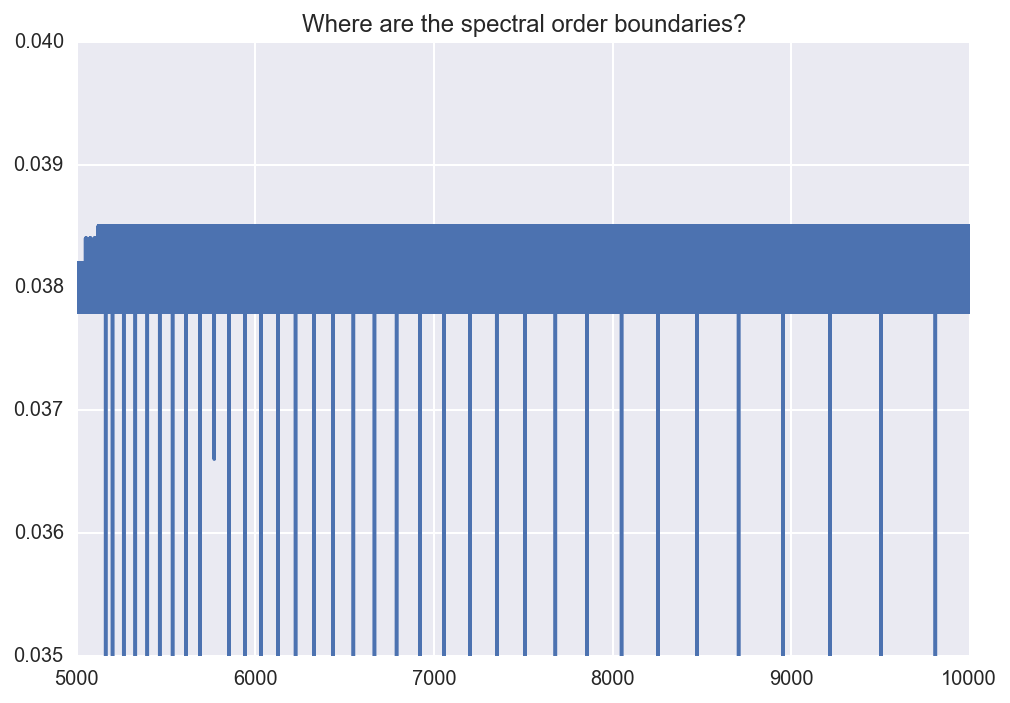

In [11]:
plt.plot(raw_dat.wavelength_AA[1:-1], dw)
plt.xlim(5000, 10000)
plt.ylim(0.035, 0.040)
plt.title("Where are the spectral order boundaries?")

In [12]:
n_boundaries = np.sum(ids)
n_boundaries

35

There are 35 places where the wavelength solution jumps.   
These are the locations of the spectral orders.

In [13]:
wl_bounds = np.append(raw_dat.wavelength_AA[ids].values, 10000.0)

## Plot the spectrum with order boundaries

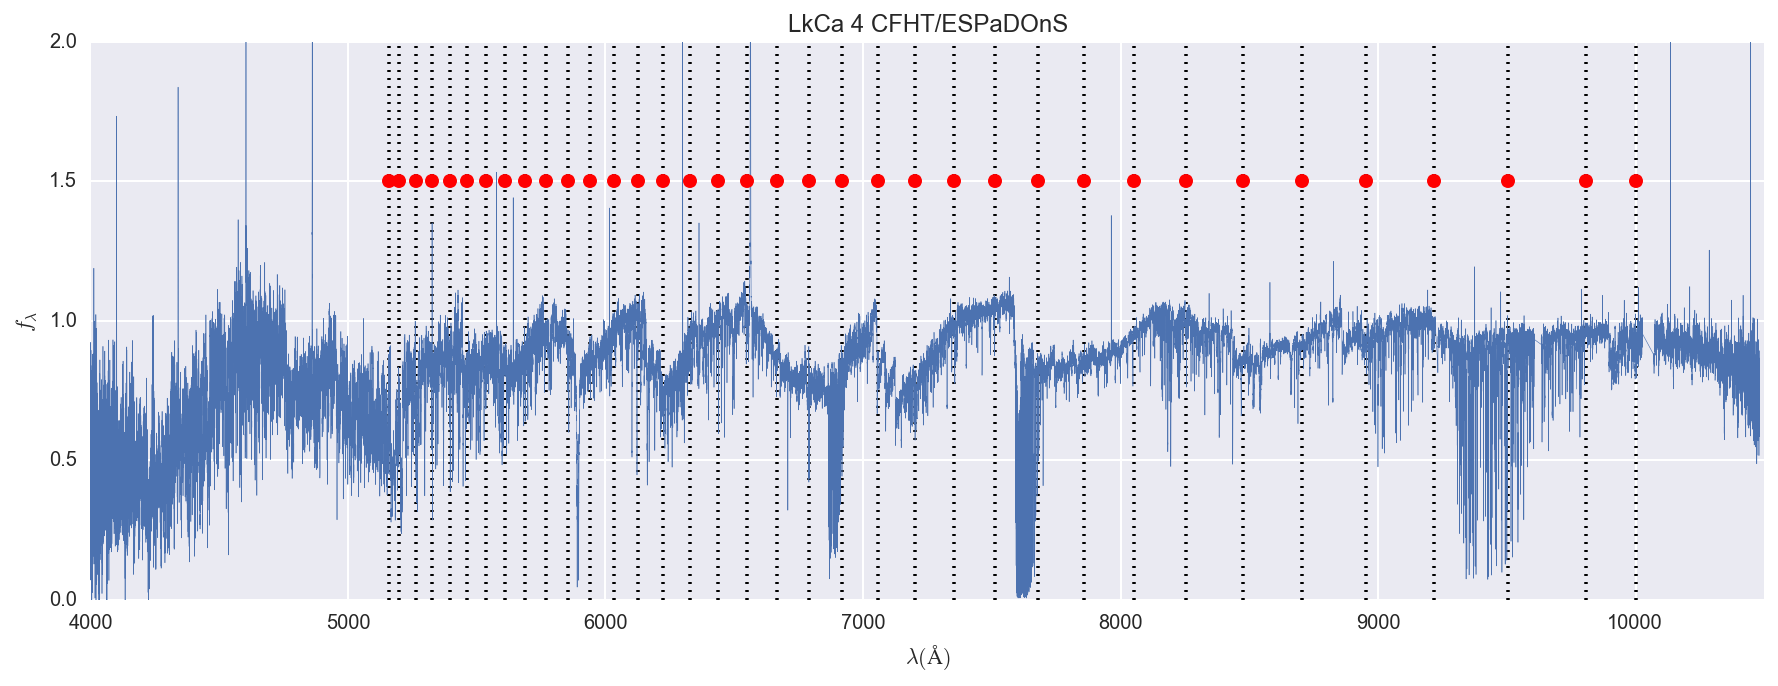

In [14]:
plt.figure(figsize=(15, 5))
plt.plot(raw_dat.wavelength_AA, raw_dat.flux, linewidth=0.3)
plt.ylim(0, 2)
plt.xlim(4000,10500)
plt.xlabel('$\lambda (\AA)$'); plt.ylabel('$f_{\lambda}$'); plt.title('LkCa 4 CFHT/ESPaDOnS')
plt.plot(wl_bounds, wl_bounds*0.0+1.5, 'ro')
plt.vlines(wl_bounds, wl_bounds*0.0, wl_bounds*0.0+2.0,
           linestyles='dotted', )

## Assign spectral order column

In [15]:
raw_dat['spec_order'] = -1

In [16]:
for i in range(n_boundaries):
    wl_ids = (raw_dat.wavelength_AA > wl_bounds[i]) & (raw_dat.wavelength_AA < wl_bounds[i+1])
    raw_dat.spec_order[wl_ids] = i

## Make up sigma column [total hack]

Let's assume the signal-to-noise ratio is 100.

In [17]:
raw_dat['sigmas'] = 0.003+np.abs(raw_dat.flux * 0.01)

Also a mask column.  Fill with 1s.

In [18]:
raw_dat['masks'] = 1

## Purge the unused parts of the spectrum

In [19]:
del raw_dat['wavelength_nm']

In [20]:
labels = raw_dat.index[raw_dat.spec_order.values == -1]
raw_dat.drop(labels, inplace=True)
raw_dat.reset_index(drop=True, inplace=True)

In [21]:
raw_dat.head()

,flux,wavelength_AA,spec_order,sigmas,masks
0,0.857002,5161.3208,0,0.011570,1
1,0.865046,5161.3586,0,0.011650,1
2,0.862660,5161.3965,0,0.011627,1
3,0.839134,5161.4349,0,0.011391,1
4,0.840304,5161.4728,0,0.011403,1


## Save it to individual hdf5 files.

In [22]:
m = 10

In [23]:
import h5py

In [24]:
ms = raw_dat.spec_order.unique()

In [25]:
for m in ms:
    out_ids = raw_dat.spec_order == m
    wls_out = raw_dat.wavelength_AA[out_ids].values
    fls_out = raw_dat.flux[out_ids].values
    sigmas_out = raw_dat.sigmas[out_ids].values
    masks_out = raw_dat.masks[out_ids].values
    
    mdir = 'eo{:03d}'.format(m)
    
    f = h5py.File("../data/reduced/optical/LkCa4_ESPaDOnS_{}.hdf5".format(mdir), "w")
    dset1 = f.create_dataset('wls', data=wls_out) #Angstroms
    dset2 = f.create_dataset('fls', data=fls_out)
    dset3 = f.create_dataset('sigmas', data=sigmas_out)
    dset4 = f.create_dataset('masks', data=masks_out)
    f.close()
    print(mdir)

eo000
eo001
eo002
eo003
eo004
eo005
eo006
eo007
eo008
eo009
eo010
eo011
eo012
eo013
eo014
eo015
eo016
eo017
eo018
eo019
eo020
eo021
eo022
eo023
eo024
eo025
eo026
eo027
eo028
eo029
eo030
eo031
eo032
eo033
eo034


In [26]:
! ls ../data/reduced/optical/

LkCa4_ESPaDOnS_eo000.hdf5 LkCa4_ESPaDOnS_eo012.hdf5 LkCa4_ESPaDOnS_eo024.hdf5
LkCa4_ESPaDOnS_eo001.hdf5 LkCa4_ESPaDOnS_eo013.hdf5 LkCa4_ESPaDOnS_eo025.hdf5
LkCa4_ESPaDOnS_eo002.hdf5 LkCa4_ESPaDOnS_eo014.hdf5 LkCa4_ESPaDOnS_eo026.hdf5
LkCa4_ESPaDOnS_eo003.hdf5 LkCa4_ESPaDOnS_eo015.hdf5 LkCa4_ESPaDOnS_eo027.hdf5
LkCa4_ESPaDOnS_eo004.hdf5 LkCa4_ESPaDOnS_eo016.hdf5 LkCa4_ESPaDOnS_eo028.hdf5
LkCa4_ESPaDOnS_eo005.hdf5 LkCa4_ESPaDOnS_eo017.hdf5 LkCa4_ESPaDOnS_eo029.hdf5
LkCa4_ESPaDOnS_eo006.hdf5 LkCa4_ESPaDOnS_eo018.hdf5 LkCa4_ESPaDOnS_eo030.hdf5
LkCa4_ESPaDOnS_eo007.hdf5 LkCa4_ESPaDOnS_eo019.hdf5 LkCa4_ESPaDOnS_eo031.hdf5
LkCa4_ESPaDOnS_eo008.hdf5 LkCa4_ESPaDOnS_eo020.hdf5 LkCa4_ESPaDOnS_eo032.hdf5
LkCa4_ESPaDOnS_eo009.hdf5 LkCa4_ESPaDOnS_eo021.hdf5 LkCa4_ESPaDOnS_eo033.hdf5
LkCa4_ESPaDOnS_eo010.hdf5 LkCa4_ESPaDOnS_eo022.hdf5 LkCa4_ESPaDOnS_eo034.hdf5
LkCa4_ESPaDOnS_eo011.hdf5 LkCa4_ESPaDOnS_eo023.hdf5


# All done!